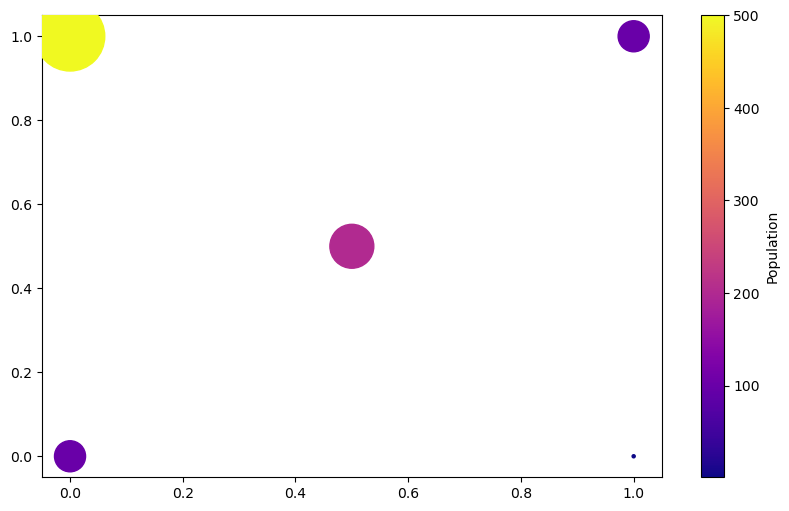

In [311]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba


n = 5

# Générer des coordonnées x et y aléatoires dans l'intervalle [0, 1]
xp = np.random.rand(n)
yp = np.random.rand(n)

# Générer des poids aléatoires dans l'intervalle [1, 500]
population = np.random.randint(1, 501, size=n)

xp = np.array([0, 1, 0, 1, 0.5])
yp = np.array([0, 0, 1, 1, 0.5])
population = np.array([100, 1, 500, 100, 200])
size = population*5


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')

In [312]:
Hs = 0.2
N = 3
Is = 50
Imin = 1
IminSol = 600
eps = 1e-1
p = 50

xt = np.linspace(0, 1, 50)
yt = np.linspace(0, 1, 50)
Xt, Yt = np.meshgrid(xt, yt)

In [313]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [314]:
@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    """
    Dans cette version, on va essayer d'imposer une surface au sol qui a une intensité minimale à l'aide d'une contrainte, 
    on ne cherche donc pas à maximiser quoique ce soit
    """
    
    
    return 0
        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)


@numba.jit(nopython = True, parallel = True)
def contrainte2(x) : 
    somme = 0
    for j in numba.prange(p) : 
        for k in numba.prange(p) : 
            sum_point = 0
            for i in numba.prange(N) : 
                di_sq = pyth(j/p, x[2*i], k/p, x[2*i+1]) + Hs**2

                sum_point += Is/(di_sq)
            if sum_point >= IminSol : 
                somme+=1
  
    return somme/(p**2)
    

In [315]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.8, 1)
myc2 = NonlinearConstraint(contrainte2, 0.7, 1)
contraintes = [myc1, myc2]
x0 = [1] * 2*N
t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
print("Valeur de la contrainte 2 : ", contrainte2(resultat.x))

temps :  0.9713411331176758
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.0
       x: [ 2.912e-01  9.449e-01  8.955e-01  5.988e-01  2.343e-01
            4.247e-01]
    nfev: 54
   maxcv: 0.0
Résultat de l'optimisation: 0.0
Valeurs optimales des variables: [0.29118018 0.94492547 0.89550013 0.59883274 0.23430185 0.42472656]
Valeur de la contrainte 1 :  0.9999953524514001
Valeur de la contrainte 2 :  0.7028


/Users/adammesbahi/anaconda3/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../var/folders/g7/ns5n8gvs4pn0vkl_qlxflbkc0000gn/T/ipykernel_20576/642254829.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


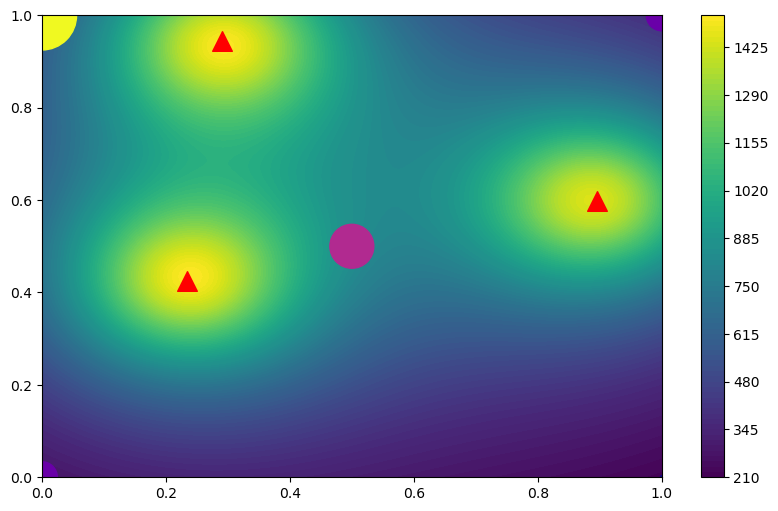

In [316]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar(cf, ax = ax)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)